In [1]:
import os, random, glob, pickle, collections, math
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
import gc
import glob
import shutil, csv, time

import utils; reload(utils)
from utils import *

from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
TRAIN_DIR = '../data/fish/train-all/'
TEST_DIR =  '../data/fish/test/' #'../RFCN/JPEGImages/'
# RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
CHECKPOINT_DIR = './checkpoints/checkpoint08/'
LOG_DIR = './logs/log08/'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BATCHSIZE = 32 # 256 #64
LEARNINGRATE = 1e-4
BG_THRESH_HI = 0.3
BG_THRESH_LO = 0.1
bags = 5
learn_round = 2
p=16
full = True

#def load_img(path, bbox, target_size=None):
#    img = Image.open(path)
#    img = img.convert('RGB')
#    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
#    if target_size:
#        cropped = cropped.resize((target_size[1], target_size[0]))
#    return cropped

#def load_img(path, bbox, target_size=None):
#    img = Image.open(path)
#    imsize = Image.open(path).size
#    height, width = bbox[2]-bbox[0], bbox[3]-bbox[1]
#    length = max(height, width)
#    for i in [0,1]:
#        if bbox[0+i]+length > imsize[0+i]:
#            bbox[0+i] = bbox[2+i] - length
#        else:
#            bbox[2+i] = bbox[0+i] + length
#    img = img.convert('RGB')
#    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
#    if target_size:
#        cropped = cropped.resize((target_size[1], target_size[0]))
#    return cropped

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    imsize = Image.open(path).size
    height, width = bbox[2]-bbox[0], bbox[3]-bbox[1]
    length = max(height, width)    
    # Make it square
    dim = [width, height]
    for i in range(2):
        offset = length - dim[0+i]
        if bbox[0+i]+length+(offset/2) > imsize[0+i]:
            bbox[0+i] = bbox[2+i] - length + (offset/2)
            bbox[2+i] = bbox[2+i] + (offset/2)
        else:
            bbox[2+i] = bbox[0+i] + length
        bbox[0+i] -= length*0.02
        bbox[2+i] += length*0.02
        
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    #if height < width:
    #    cropped = cropped.rotate(-90)
    return cropped

def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [3]:
file_name = 'GTbbox_df.pickle'
if os.path.exists('../data/'+file_name):
    print ('Loading from file '+file_name)
    GTbbox_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_df = pd.DataFrame(columns=['image_folder', 'image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')

    for c in crop_classes:
        print(c)
        j = json.load(open('../data/fish/annos1/{}.json'.format(c), 'r'))
        for l in j: 
            filename = l["filename"]
            head, image_file = os.path.split(filename)
            basename, file_extension = os.path.splitext(image_file) 
            image = Image.open(TRAIN_DIR+c+'/'+image_file)
            width_image, height_image = image.size
            for i in range(len(l["annotations"])):
                a = l["annotations"][i]
                xmin = (a["x"])
                ymin = (a["y"])
                width = (a["width"])
                height = (a["height"])
                delta_width = p/(COLS-2*p)*width
                delta_height = p/(ROWS-2*p)*height
                xmin_expand = xmin-delta_width
                ymin_expand = ymin-delta_height
                xmax_expand = xmin+width+delta_width
                ymax_expand = ymin+height+delta_height
                assert max(xmin_expand,0)<min(xmax_expand,width_image)
                assert max(ymin_expand,0)<min(ymax_expand,height_image)
                GTbbox_df.loc[len(GTbbox_df)]=[c, image_file,i,a["class"],max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]
                if a["class"] != c: print(GTbbox_df.tail(1))
                    
    GTbbox_df.to_pickle('../data/'+file_name)

Loading from file GTbbox_df.pickle


In [4]:
GTbbox_df.shape

(4371, 8)

In [5]:
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(row[0], row[1])
            fish = row[3]
            bbox = row[4:8]
            cropped = load_img(TRAIN_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i,FISH_CLASSES.index(fish)] = 1
            i += 1
        yield (batch_x, batch_y)

def test_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        #batch_y = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = row[1]
            fish = row[3]
            bbox = row[4:8]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            # batch_y[i,FISH_CLASSES.index(fish)] = 1
            i += 1
        yield (batch_x)
        
train_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [6]:
# Read in the validation set
df_valid = pd.read_csv('../image_validation_set.csv')
valid_set = df_valid[df_valid['Validation']==1].file_name.tolist()
#train data prepare
# train_df, valid_df = train_test_split(GTbbox_df, test_size = 0.2, random_state=1986, stratify=GTbbox_df['crop_class'])
train_df = GTbbox_df[~GTbbox_df['image_file'].isin(valid_set)]
valid_df = GTbbox_df[GTbbox_df['image_file'].isin(valid_set)]

nb_perClass = int(BATCHSIZE / len(FISH_CLASSES)) 
samples_per_epoch=BATCHSIZE*math.ceil(train_df.groupby('crop_class').size()['ALB']/nb_perClass)

In [7]:
if full == True:
    train_df = GTbbox_df
    samples_per_epoch=BATCHSIZE*math.ceil(train_df.groupby('crop_class').size()['ALB']/nb_perClass)

In [8]:
def generator_test(gen, df, DIR):
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(row[0], row[1])
            fish = row[3]
            bbox = row[4:8]
            cropped = load_img(DIR+image_file,bbox,target_size=(ROWS,COLS))
        #return cropped
        img = np.expand_dims(cropped,0)
        aug_iter = gen.flow(img)
        aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
        return aug_imgs, cropped

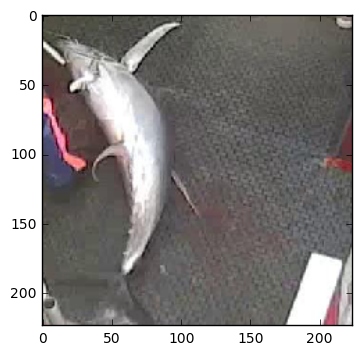

In [9]:
aug_imgs, cropped = generator_test(train_datagen, df=train_df, DIR = TRAIN_DIR)
# Augmented data
plt.imshow(cropped)

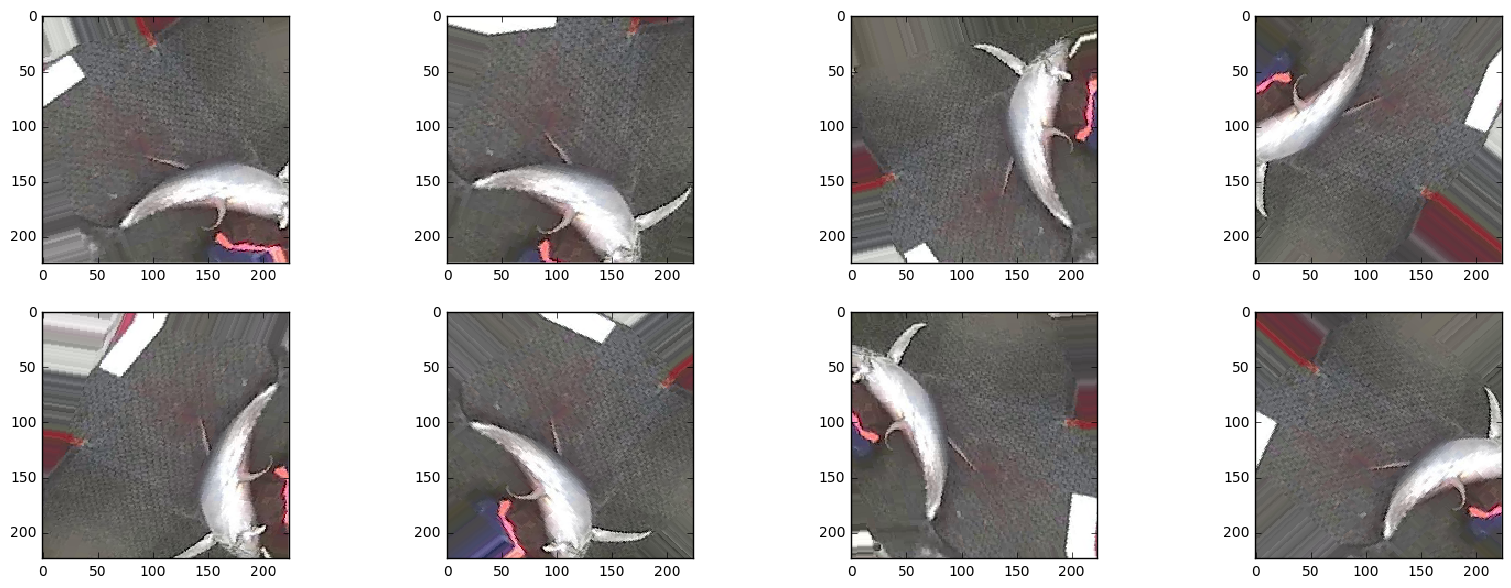

In [10]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [11]:
valid_df[:2]

,image_folder,image_file,crop_index,crop_class,xmin,ymin,xmax,ymax
0,ALB,img_00003.jpg,0.0,ALB,377.0,66.0,730.0,173.0
1,ALB,img_00003.jpg,1.0,ALB,670.0,95.0,1008.0,219.0


In [12]:
# validation_data (valid_x,valid_y)
df_1 = valid_df[valid_df.crop_class != 'NoF']
l = valid_df.groupby('crop_class').size()
# l.pop('NoF')
nb_NoF_valid = math.ceil(l.sum()/10)
#df_2 = valid_df[valid_df.crop_class == 'NoF'].sample(n=nb_NoF_valid)
#valid_df = pd.concat([df_1,df_2], axis=0)
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    row = row.tolist()
    image_file = os.path.join(row[0], row[1])
    fish = row[3]
    bbox = row[4:8]
    cropped = load_img(TRAIN_DIR+image_file,bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y[i,FISH_CLASSES.index(fish)] = 1
    i += 1

In [13]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

# tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False, write_images=True)

In [ ]:
#Resnet50
#top layer training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
x = Dense(256, init='glorot_normal')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LEARNINGRATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)


In [ ]:
# train the model on the new data for a few epochs
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=12, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule],  # , tensorboard
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

In [ ]:
del model
gc.collect()

In [ ]:
# Resnet50
# fine tuning
model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
import glob
start_layer = 38

files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

for layer in model.layers[:start_layer]:
    layer.trainable = False
for layer in model.layers[start_layer:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule],  # , tensorboard
                    validation_data=(valid_x,valid_y), nb_worker=1, pickle_safe=True)

In [ ]:
# Save at every epoch
model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

#resume training
files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=4, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule], # , tensorboard
                    validation_data=(valid_x,valid_y), nb_worker=1, pickle_safe=True)

In [ ]:
GTbbox_df[:2]

In [ ]:
# Load up YOLO bounding boxes for each class
import glob
# all_files = glob.glob(os.path.join('../yolo_coords', "*.txt"))
# allFiles = [f for f in all_files if 'FISH' in f]
all_files = glob.glob(os.path.join('../darknet/results', "*.txt"))
allFiles = [f for f in all_files if 'FISH640.' in f]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=None, sep = " ", names = ['fname', 'proba', 'x0', 'y0', 'x1', 'y1'])
    df['class'] = file_.split('_')[-1].split('.')[0]
    list_.append(df)
yolo_frame = pd.concat(list_)
# Cut off the predictions on a probabilty
yolo_frame = yolo_frame[yolo_frame['proba']>0.6]
# Sort the predictions on the area 
yolo_frame['proba_max'] = df.groupby('fname')['proba'].transform('max')
yolo_frame['area'] = (yolo_frame['x1']-yolo_frame['x0']) * (yolo_frame['y1']-yolo_frame['y0'])
yolo_frame = yolo_frame.sort(['fname','area'], ascending=[1, 0]).reset_index(drop=True)
yolo_frame = pd.concat([yolo_frame[(yolo_frame['proba']==yolo_frame['proba_max'])&(yolo_frame['proba_max']<0.80)],
                       yolo_frame[yolo_frame['proba'] >= .80]], axis = 0)
yolo_frame[:5]

In [ ]:
print len(yolo_frame.fname.unique())
yolo_frame.shape

In [ ]:
file_name = 'GTbbox_test_df.pickle'
if False: #os.path.exists('../data/'+file_name):
    print ('Loading from file '+file_name)
    GTbbox_test_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_test_df = pd.DataFrame(columns=['image_folder', 'image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  
    iddict = {}
    for c in ['test']:
        print(c)
        for l in range(yolo_frame.shape[0]): 
            image_file, proba, xmin, ymin, xmax, ymax, fish_class, area = yolo_frame.iloc[l].values.tolist()    
            if image_file in iddict:
                iddict[image_file] += 1
            else:
                iddict[image_file] = 0
            image = Image.open(TEST_DIR+c+'/'+image_file+'.jpg')
            width_image, height_image = image.size
            width = xmax - xmin
            height = ymax - ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmin+width+delta_width
            ymax_expand = ymin+height+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            GTbbox_test_df.loc[len(GTbbox_test_df)] = [c, image_file+'.jpg', iddict[image_file],fish_class,max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]                    
    GTbbox_test_df = GTbbox_test_df.sort(['image_file','crop_index']).reset_index(drop=True)
    GTbbox_test_df.to_pickle('../data/'+file_name)

In [ ]:
GTbbox_test_df[:2]

In [ ]:
#image_file, proba, x0, y0, x1, y1, fish_class = yolo_frame.iloc[0].values.tolist()    
#image = Image.open(TEST_DIR+c+'/'+image_file+'.jpg')
#image
aug_imgs, cropped = generator_test(train_datagen, df=GTbbox_test_df, DIR = '../data/fish/')
# Augmented data
plt.imshow(cropped)

In [ ]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [ ]:
#del model
gc.collect()

In [ ]:
GTbbox_test_df.head(3)

In [ ]:
def test_generator(df, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print(batch_index)
        yield(batch_x)

In [ ]:
import glob
files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
min_id = np.array(val_losses).argsort()[:bags].tolist()

In [ ]:
# Loop the the lowest val losses and get a prediction for each
test_preds_ls = []
for index in min_id:
    index = val_losses.index(min(val_losses))
    print('Loading model from checkpoints file ' + files[index])
    test_model = load_model(files[index])
    test_model_name = files[index].split('/')[-2][-1:]+'_'+files[index].split('/')[-1]
    test_preds_ls.append(test_model.predict_generator(test_generator(df=GTbbox_test_df, datagen = train_datagen), 
                                         val_samples=GTbbox_test_df.shape[0])) 
    del test_model
    gc.collect()

In [ ]:
test_preds = sum(test_preds_ls)/len(test_preds_ls)

In [ ]:
GTbbox_test_df[:3]

In [ ]:
columns = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
yolo_pred_df = pd.DataFrame(test_preds, columns=columns)

In [ ]:
yolo_pred_df['image_file'] = GTbbox_test_df.image_file
yolo_pred_df['crop_index'] = GTbbox_test_df.crop_index
yolo_pred_df[yolo_pred_df['crop_index']<2].shape

In [ ]:
yolo_pred_df = yolo_pred_df.groupby(['image_file'], as_index=False).mean().reset_index(drop=True)
yolo_pred_df.drop('crop_index', axis=1, inplace=True)

In [ ]:
timestr = time.strftime("%Y%m%d")
if full:
    subm_name = '../sub/subm_full_resnet_box640_cut0.7_' + timestr + '.csv' #'.csv.gz'
else:
    subm_name = '../sub/subm_part_resnet_box640_cut0.7_' + timestr + '.csv' #'.csv.gz'

In [ ]:
yolo_pred_df.to_csv(subm_name, index=False)#, compression='gzip')
FileLink(subm_name)